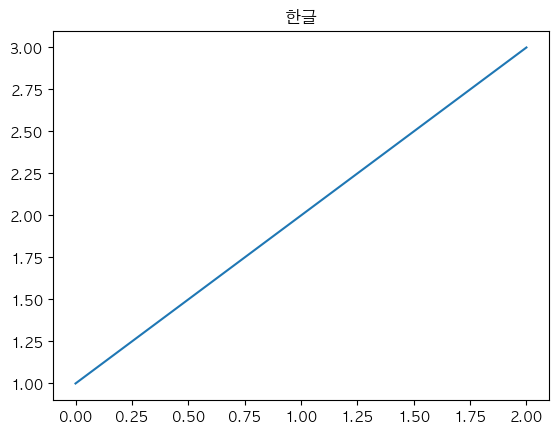

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family="AppleGothic") # 라이브러리 불러오기와 함께 한번만 실행
plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max.columns', None)

PATH = './data/'
df = pd.read_csv(PATH + '액체_모델용.csv')

In [2]:
df.head(2)

,Datetime,ETA_Year,ETA_Month,ETA_Day,ETA_Hour,호출부호,입항일시,출항일시,접안_대기시간_분,출항_대기시간_분,Service_Time_Start,Service_Time_End,계선장소_코드,계선장소_숫자,계선장소명,선박용도,Service_Time_분,대기율,총톤수,재화중량톤수,"선박제원(총길이, m)","선박제원(너비, m)",만재흘수(m),깊이(m),길이1(m),ETA_Minute,풍속(m/s),풍향(deg),GUST풍속(m/s),현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg),액체화물
0,2020-01-01 01:00:00,2020,1,1,1,88238,2020-01-01 01:05:00,2020-01-01 08:15,0,0.0,2020-01-01 01:05:00,2020-01-01 08:15:00,MBU,1,SK2부두 01,석유제품 운반선,430.0,0.0,700.0,0.0,70.9,12.0,3.9,5.35,66.01,5,9.3,330.0,12.2,1028.8,43.0,4.3,17.5,4.2,2.8,2.0,10.7,49.0,1
1,2020-01-01 03:00:00,2020,1,1,3,DSRB9,2020-01-01 03:05:00,2020-01-01 14:55,0,0.0,2020-01-01 03:05:00,2020-01-01 14:55:00,MBL,1,가스부두,LPG 운반선,710.0,0.0,2689.0,2999.0,96.0,15.0,7.2,7.20,90.10,5,12.6,315.0,15.3,1028.5,44.0,4.3,17.4,3.9,2.2,1.5,9.1,48.0,1


## 순선석 점유율(2022)
- 2022년 개별 선석 가용시간(working days)
- 2022년 개별 선석 서비스 타임 합계
 - 선석작업시간/ 총선석시간

In [3]:
# 최근 1년(2022년)의 선석별 가용시간 

df22 = df[df['ETA_Year'] == 2022]
df22['date_part'] = df22['Datetime'].str[5:10]

temp_days = df22.groupby(['계선장소명'])['date_part'].nunique().reset_index()
temp_days.columns = ['계선장소명', 'working_days']
temp_days['normal_days'] = 360
temp_days.head()

,계선장소명,working_days,normal_days
0,1부두 01,16,360
1,2부두 01,15,360
2,2부두 02,69,360
3,2부두 03,44,360
4,3부두 01,22,360


In [4]:
temp_days['working_days'].value_counts()

1      6
4      4
16     3
3      3
25     2
      ..
104    1
72     1
324    1
359    1
239    1
Name: working_days, Length: 87, dtype: int64

In [5]:
# 22년 선석 서비스 타임 합계
temp_service = df22.groupby('계선장소명')['Service_Time_분'].sum().reset_index()
temp_service.columns = ['계선장소명', 'service_time_sum']
# temp_service.head()

temp = pd.merge(temp_days, temp_service, how= 'left', on = '계선장소명')
temp['22년_선석별점유율'] = temp['service_time_sum'] / (temp['working_days']*24*60) 
temp = temp.sort_values(by = '22년_선석별점유율', ascending = False)

occupied_Ratio = temp[['계선장소명', '22년_선석별점유율']]
occupied_Ratio.head()

,계선장소명,22년_선석별점유율
45,미포부두 02,6.649306
66,염포부두 02,5.671181
87,장생포호안,4.351121
88,정박지-E1,3.936442
28,SK2부두 01,3.918487


## 선석별 대기율(2022)
- 선석별 서비스 타임 합(temp_service):minute
- 선석별 대기 시간 합: minute

In [6]:
temp_waiting = df22.groupby('계선장소명')['접안_대기시간_분'].sum().reset_index()

temp_waiting.columns = ['계선장소명', '총대기시간_분']
# temp_waiting.head()

temp_ratio = pd.merge(temp_waiting, temp_service, how= 'left', on = '계선장소명')
temp_ratio['대기율'] = temp_ratio['총대기시간_분'] / temp_ratio['service_time_sum'] * 100
# temp_ratio.head()

W_ratio = temp_ratio[['계선장소명', '대기율']]
W_ratio.head()

,계선장소명,대기율
0,1부두 01,19.225839
1,2부두 01,0.000000
2,2부두 02,30.187672
3,2부두 03,8.942468
4,3부두 01,26.274584


## 점유율 대비 대기율(2022)
- 점유율 대비 대기율(대기율 / 점유율) : 높을수록 비어있는데, 대기는 많이 되어 비효율적인 선석

In [7]:
result = pd.merge(occupied_Ratio, W_ratio, how= 'left', on = '계선장소명')
result['점유율_대비_대기율'] = result['대기율'] / result['22년_선석별점유율']
result = result.sort_values(by = '점유율_대비_대기율', ascending = False)
# result.head(10)

result2 = pd.merge(result, temp_days, how= 'left', on = '계선장소명')
df = result2.copy()
df.head()

,계선장소명,22년_선석별점유율,대기율,점유율_대비_대기율,working_days,normal_days
0,정박지-M4,0.668214,70.700905,105.805817,79,360
1,정박지-M3,0.815610,66.273646,81.256549,46,360
2,정박지-M6,0.830271,52.896374,63.709734,66,360
3,대한통운신항부두,0.623843,37.291280,59.776746,3,360
4,용잠부두 02,0.786795,41.934932,53.298436,129,360


## 순작업시간 점유율(2022)
- 선석 작업시간 / 정상적인 선석 작업시간

In [8]:
# 순선석 점유율 : 22년_선석별점유율
df = df.merge(temp_service, how= 'left', on = '계선장소명')
df['순작업시간_점유율'] = df['service_time_sum'] / (df['normal_days'] * 24 * 60)
df = df.rename(columns = {'22년_선석별점유율':'순선석_점유율'})

df.head()

,계선장소명,순선석_점유율,대기율,점유율_대비_대기율,working_days,normal_days,service_time_sum,순작업시간_점유율
0,정박지-M4,0.668214,70.700905,105.805817,79,360,76016.0,0.146636
1,정박지-M3,0.815610,66.273646,81.256549,46,360,54026.0,0.104217
2,정박지-M6,0.830271,52.896374,63.709734,66,360,78909.0,0.152216
3,대한통운신항부두,0.623843,37.291280,59.776746,3,360,2695.0,0.005199
4,용잠부두 02,0.786795,41.934932,53.298436,129,360,146155.0,0.281935


### 순선석점유율 & 순작업시간 점유율 비교 시각화

In [9]:
# 정박지는 제외
df_ = df[~df['계선장소명'].str.contains('정박')]
df_ = df_.sort_values(by = '점유율_대비_대기율', ascending = False)
df_

,계선장소명,순선석_점유율,대기율,점유율_대비_대기율,working_days,normal_days,service_time_sum,순작업시간_점유율
3,대한통운신항부두,0.623843,37.291280,59.776746,3,360,2695.0,0.005199
4,용잠부두 02,0.786795,41.934932,53.298436,129,360,146155.0,0.281935
5,용잠부두 01,0.742642,34.554158,46.528676,42,360,44915.0,0.086642
7,6부두 02,0.654968,27.974880,42.711830,13,360,12261.0,0.023652
8,9부두 01,0.791214,27.780958,35.111823,23,360,26205.0,0.050550
...,...,...,...,...,...,...,...,...
96,현대미포의장안벽 01,0.425347,0.000000,0.000000,2,360,1225.0,0.002363
95,현대미포의장안벽 03,0.631944,0.000000,0.000000,1,360,910.0,0.001755
94,신항부두작업장,0.119792,0.000000,0.000000,4,360,690.0,0.001331
93,신항컨테이너부두 03,0.430556,0.000000,0.000000,1,360,620.0,0.001196


In [10]:
temp = df_.head(7)
name_list = temp['계선장소명'].tolist()

temp[['계선장소명', '대기율', '점유율_대비_대기율', '순선석_점유율','순작업시간_점유율']]

,계선장소명,대기율,점유율_대비_대기율,순선석_점유율,순작업시간_점유율
3,대한통운신항부두,37.291280,59.776746,0.623843,0.005199
4,용잠부두 02,41.934932,53.298436,0.786795,0.281935
5,용잠부두 01,34.554158,46.528676,0.742642,0.086642
7,6부두 02,27.974880,42.711830,0.654968,0.023652
8,9부두 01,27.780958,35.111823,0.791214,0.050550
10,온산1부두,32.414845,34.084249,0.951021,0.269456
13,3부두 01,26.274584,31.481801,0.834596,0.051003


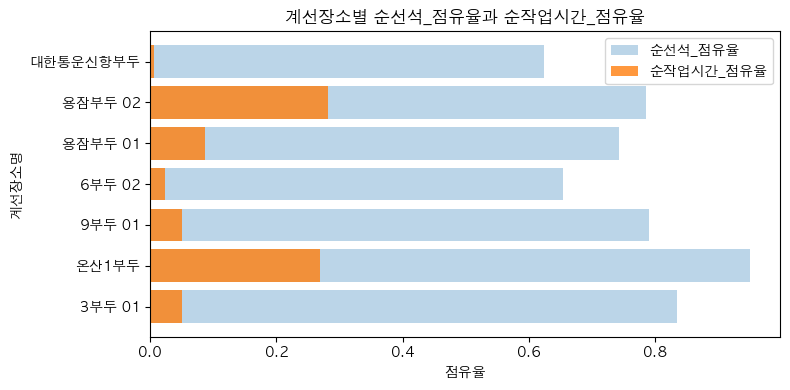

In [11]:
# "계선장소명" 컬럼을 주어진 순서대로 정렬
temp['계선장소명'] = pd.Categorical(temp['계선장소명'], categories=name_list, ordered=True)
temp = temp.sort_values(by='점유율_대비_대기율', ascending = True)

# 그래프 생성
plt.figure(figsize=(8, 4))  # 그래프 크기 설정

# X 축에 순선석_점유율, Y 축에 계선장소명을 사용한 수평 막대 그래프
plt.barh(temp['계선장소명'], temp['순선석_점유율'], label='순선석_점유율', alpha=0.3)
plt.barh(temp['계선장소명'], temp['순작업시간_점유율'], label='순작업시간_점유율', alpha=0.8)
# 그래프에 레이블과 범례 추가
plt.xlabel('점유율')
plt.ylabel('계선장소명')
plt.title('계선장소별 순선석_점유율과 순작업시간_점유율')
plt.legend()

# 그래프 출력
plt.tight_layout()  # 그래프 간격 조정
plt.show()